# 流程

# ----------预处理----------
### 1 pbf->osm（osmcovert）

In [1]:
import os
import time
import math

import xml.dom.minidom as xmldom
import pandas as pd
import geopandas as gpd

from shapely.geometry import Polygon
from shapely.geometry import Point
from shapely import affinity

import numpy as np

from matplotlib import pyplot as plt
from matplotlib.lines import Line2D

import osmnx as ox

from descartes import PolygonPatch

from PIL import Image

ModuleNotFoundError: No module named 'osmnx'

In [2]:
#pbf转码为osm
def convert_pbf_osm (pbf_file) :
    starttime = time.time()
    base_path = 'E:/AAA_Study/202003_GraduationProject/'
    osmconvert_path = base_path + 'osmconvert'
    osm_file = pbf_file.replace('.osm.pbf','.osm')
    
    terminal_code = '{} {} > {}'.format(osmconvert_path,pbf_file,osm_file)
    os.system(terminal_code)
    endtime = time.time()
    print ('{} converted to {}'.format(pbf_file,osm_file))
    print('step total time:', round(endtime - starttime, 2),'secs')

In [27]:
OSMPBF_PATH = "E:/AAA_Study/202003_GraduationProject/MapData/OSMData/sources/taiwan_latest.osm.pbf"
convert_pbf_osm(OSMPBF_PATH)

E:/AAA_Study/202003_GraduationProject/MapData/OSMData/sources/taiwan_latest.osm.pbf converted to E:/AAA_Study/202003_GraduationProject/MapData/OSMData/sources/taiwan_latest.osm
step total time: 13.04 secs


### 2 国家osm->university.osm（osmfilter）

In [3]:
#campus提取
def campus_extract(osmfilename):
    starttime = time.time()
    sel_osmkey = 'amenity'
    sel_osmvalue = ['university']
    country_name = os.path.split(osmfilename)[1]
    osmfilter_path = 'E:/AAA_Study/202003_GraduationProject/' + 'osmfilter'
    
    for value in sel_osmvalue:
        sel_element = sel_osmkey + "=" + value
        print (sel_element)
        output_sel = osmfilename.replace('.osm','_{}.osm'.format(value))
        print (output_sel)
        terminal_code = '{} {} --keep="{}" -o={}'.format(osmfilter_path,osmfilename,sel_element,output_sel)
        os.system(terminal_code)
    endtime = time.time()
    print(country_name + "----------" + sel_element + " extracted success!")
    print('step total time:', round(endtime - starttime, 2),'secs')

In [28]:
OSM_PATH = "E:/AAA_Study/202003_GraduationProject/MapData/OSMData/sources/taiwan_latest.osm"
campus_extract(OSM_PATH)

amenity=university
E:/AAA_Study/202003_GraduationProject/MapData/OSMData/sources/taiwan_latest_university.osm
taiwan_latest.osm----------amenity=university extracted success!
step total time: 20.49 secs


# ----------筛选解析----------
### 3 筛选有效数据

In [3]:
def parseValidData (INPUT_OSM):
    '''
    对第一步提取后的osm校园文件进行数据清洗，return sub_element_n,sub_element_w
    '''
    print('...')
    dom = xmldom.parse(INPUT_OSM)
    element = dom.documentElement
    sub_element_n = element.getElementsByTagName("node")
    sub_element_w_raw = element.getElementsByTagName("way")
    print('"way" element raw data:',len(sub_element_w_raw))
    
    for i in range(len(sub_element_w_raw)):
        way_tags = sub_element_w_raw[i].getElementsByTagName("tag")
        string = ''
        for j in range(len(way_tags)):   
            string = string + way_tags[j].getAttribute('k')+way_tags[j].getAttribute('v')
        if 'university' not in string or 'building' in string:
            element.removeChild(sub_element_w_raw[i])
    sub_element_w = element.getElementsByTagName("way")
    print('"way" element:',len(sub_element_w))
    print('"node" element:',len(sub_element_n))
    print('data parsing done!')
    return sub_element_n,sub_element_w

In [31]:
INPUT_OSM = 'E:/AAA_Study/202003_GraduationProject/MapData/OSMData/sources/extracted/australia_latest_university.osm'
sub_element_n,sub_element_w = parseValidData(INPUT_OSM)

...
"way" element raw data: 521
"way" element: 209
"node" element: 7703
data parsing done!


### 4.1 解析数据，得到基础POI信息

In [2]:
def hav(theta):
    s = math.sin(theta / 2)
    return s * s
 
def get_distance_hav(lat0, lng0, lat1, lng1):
    "用haversine公式计算球面两点间的距离。"
    EARTH_RADIUS=6371           # 地球平均半径，6371km
    # 经纬度转换成弧度
    lat0 = math.radians(lat0)
    lat1 = math.radians(lat1)
    lng0 = math.radians(lng0)
    lng1 = math.radians(lng1)
 
    dlng = math.fabs(lng0 - lng1)
    dlat = math.fabs(lat0 - lat1)
    h = hav(dlat) + math.cos(lat0) * math.cos(lat1) * hav(dlng)
    distance = 2 * EARTH_RADIUS * math.asin(math.sqrt(h))
 
    return distance*1000

def getSitePOIData (sub_element_n,sub_element_w):
    '''
    提取全部site的POI信息，返回DataFrame
    '''
    starttime = time.time()
    site_poi_data_stack = []
    POIcolumns = ['OSMID','name','center_lat','center_lon','north','south','east','west',
                  'off_north','off_south','off_east','off_west','site_analyze_length','site_analyze_width']
    
    for i in range(len(sub_element_w)):
        OSMID = sub_element_w[i].getAttribute('id')
        temp_lat = []
        temp_lon = []
        name = ''
        way_tags = sub_element_w[i].getElementsByTagName("tag")
        for j in range(len(way_tags)):    
            if way_tags[j].getAttribute('k') == 'name':
                name = way_tags[j].getAttribute('v')
                break
                
        way_nds = sub_element_w[i].getElementsByTagName("nd")
        for k in range(len(way_nds)-1):
            node_id = way_nds[k].getAttribute('ref')
            for m in range(len(sub_element_n)):
                if sub_element_n[m].getAttribute('id') == node_id:
                    temp_lat.append(float(sub_element_n[m].getAttribute('lat')))
                    temp_lon.append(float(sub_element_n[m].getAttribute('lon')))
                    break
        center_lat = sum(temp_lat)/len(temp_lat)
        center_lon = sum(temp_lon)/len(temp_lon)
        
        off_north = max(temp_lat)+(max(temp_lat)-center_lat)
        off_south = min(temp_lat)-(center_lat-min(temp_lat))
        off_east = max(temp_lon)+(max(temp_lon)-center_lon)
        off_west = min(temp_lon)-(center_lon-min(temp_lon))
        
        length = get_distance_hav(off_north,center_lon,off_south,center_lon)
        width = get_distance_hav(center_lat,off_east,center_lat,off_west)

        site_poi_data_stack.append([OSMID,name,center_lat,center_lon,max(temp_lat),min(temp_lat),max(temp_lon),min(temp_lon),
                                   off_north,off_south,off_east,off_west,length,width])
        
    sitePOIData = pd.DataFrame(site_poi_data_stack,columns=POIcolumns)
    endtime = time.time()
    print('step total time:', round(endtime - starttime, 2),'secs')
    return sitePOIData

In [95]:
sitePOIData = getSitePOIData(sub_element_n,sub_element_w)
print('data shape:',sitePOIData.shape)
sitePOIData.head()

step total time: 6.66 secs
data shape: (112, 14)


,OSMID,name,center_lat,center_lon,north,south,east,west,off_north,off_south,off_east,off_west,site_analyze_length,site_analyze_width
0,4342051,Campus Middelheim Universiteit Antwerpen,51.184640,4.419828,51.185508,51.183135,4.421802,4.418502,51.186377,51.181630,4.423775,4.417176,527.842317,459.953646
1,4382349,Campus Groenenborger Universiteit Antwerpen,51.178389,4.415759,51.179614,51.176690,4.417272,4.413399,51.180838,51.174991,4.418784,4.411040,650.134497,539.859378
2,18947151,Campus Drie Eiken Universiteit Antwerpen,51.161305,4.407092,51.168171,51.152996,4.416285,4.400370,51.175037,51.144688,4.425479,4.393649,3374.632590,2219.636801
3,22953763,Universiteit Antwerpen,51.224340,4.411428,51.224746,51.223916,4.412132,4.410716,51.225153,51.223492,4.412835,4.410003,184.628056,197.215793
4,22953784,,51.220968,4.409568,51.221311,51.220720,4.410042,4.409196,51.221653,51.220472,4.410515,4.408825,131.387925,117.725281


In [35]:
OUTPUT_CSV = 'E:/AAA_Study/202003_GraduationProject/MapData/OSMData/POI_extract_campus/belgium_latest_university.csv'
sitePOIData.to_csv(OUTPUT_CSV,index=0,encoding='utf-8-sig')

### 4.2 解析得到全部场地经纬度轮廓

In [2]:
def get_latlon_shape(sub_element_n,sub_element_w):
    '''
    
    '''
    print('......')
    starttime = time.time()
    unprojected_gdf = pd.DataFrame(columns=['OSMID','geometry_type','geometry'])
    
    for i in range(len(sub_element_w)):
        geofence =[]
        OSMID = sub_element_w[i].getAttribute('id')
        coords = []
        way_nds = sub_element_w[i].getElementsByTagName("nd")
        if len(way_nds)>=4:
            for j in range(len(way_nds)):
                node_id = way_nds[j].getAttribute('ref')
                for k in range(len(sub_element_n)):
                    if sub_element_n[k].getAttribute('id') == node_id:
                        coords.append((float(sub_element_n[k].getAttribute('lon')),float(sub_element_n[k].getAttribute('lat'))))
                        break
            geofence.append({'OSMID': OSMID,'geometry_type':'POLYGON','geometry': coords})
            geofenceDf = pd.DataFrame(geofence)

            geometryList=[]
            for m in range(0, len(geofenceDf)):
                geofencePolygon = Polygon(geofenceDf.iloc[m]['geometry'])
                geometryList.append(geofencePolygon)
            gdf = gpd.GeoDataFrame(geofenceDf, geometry=geometryList)
            gdf.crs =  '+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs'

            unprojected_gdf = pd.concat([unprojected_gdf,gdf])
        else:
            print('invalid polygon, id:',OSMID)
        
    endtime = time.time()
    print('step total time:', round(endtime - starttime, 2),'secs')
    print('all sites gdf projected!',unprojected_gdf.shape)
    return unprojected_gdf

In [4]:
def site_unnproj_gdf_batch_processing():
    '''
    对所有osm文件批量处理
    '''
    osm_files_path = 'E:/AAA_Study/202003_GraduationProject/MapData/OSMData/sources/extracted'
    osm_files = os.listdir(osm_files_path)
    site_gdf_all = pd.DataFrame(columns=['OSMID','geometry_type','geometry'])
    for i in range(len(osm_files)):
        filename = os.path.splitext(osm_files[i])[0]
        country_name = filename[0:filename.find('_latest_university')]
        print('CURRENT PROCESSING:',country_name)
        sub_element_n,sub_element_w = parseValidData(os.path.join(osm_files_path,osm_files[i]))
        sites_projected_gdf = get_latlon_shape(sub_element_n,sub_element_w)
        site_gdf_all = pd.concat([site_gdf_all,sites_projected_gdf])

        print('done!'+'\n')
    return site_gdf_all
        
#*************************运行**************************
site_unproj_gdf_data = site_unnproj_gdf_batch_processing()
site_unproj_gdf_data

CURRENT PROCESSING: australia
...
"way" element raw data: 521
"way" element: 209
"node" element: 7703
data parsing done!
......
step total time: 4.38 secs
all sites gdf projected! (209, 3)
done!

CURRENT PROCESSING: austria
...
"way" element raw data: 457
"way" element: 65
"node" element: 7012
data parsing done!
......
step total time: 1.35 secs
all sites gdf projected! (65, 3)
done!

CURRENT PROCESSING: belgium
...
"way" element raw data: 513
"way" element: 112
"node" element: 9763
data parsing done!
......
step total time: 3.53 secs
all sites gdf projected! (112, 3)
done!

CURRENT PROCESSING: brazil
...
"way" element raw data: 2962
"way" element: 1944
"node" element: 31687
data parsing done!
......
step total time: 112.39 secs
all sites gdf projected! (1944, 3)
done!

CURRENT PROCESSING: canada
...
"way" element raw data: 427
"way" element: 162
"node" element: 9889
data parsing done!
......
step total time: 6.13 secs
all sites gdf projected! (162, 3)
done!

CURRENT PROCESSING: china


,OSMID,geometry_type,geometry
0,4850410,POLYGON,"POLYGON ((115.81775 -31.97393, 115.81583 -31.9..."
0,4983964,POLYGON,"POLYGON ((115.82401 -32.06877, 115.82470 -32.0..."
0,5105371,POLYGON,"POLYGON ((150.87801 -34.40178, 150.87752 -34.4..."
0,5118498,POLYGON,"POLYGON ((143.89002 -37.62390, 143.88984 -37.6..."
0,5179347,POLYGON,"POLYGON ((144.95895 -37.77132, 144.95871 -37.7..."
...,...,...,...
0,798148183,POLYGON,"POLYGON ((-75.20919 39.94483, -75.20923 39.944..."
0,799506110,POLYGON,"POLYGON ((-84.38140 33.75727, -84.38031 33.757..."
0,801420153,POLYGON,"POLYGON ((-112.63938 45.21060, -112.63563 45.2..."
0,801828259,POLYGON,"POLYGON ((-80.90827 35.13527, -80.90876 35.135..."


In [5]:
site_unproj_gdf_data.reset_index(drop=True, inplace=True)
site_unproj_gdf_data

,OSMID,geometry_type,geometry
0,4850410,POLYGON,"POLYGON ((115.81775 -31.97393, 115.81583 -31.9..."
1,4983964,POLYGON,"POLYGON ((115.82401 -32.06877, 115.82470 -32.0..."
2,5105371,POLYGON,"POLYGON ((150.87801 -34.40178, 150.87752 -34.4..."
3,5118498,POLYGON,"POLYGON ((143.89002 -37.62390, 143.88984 -37.6..."
4,5179347,POLYGON,"POLYGON ((144.95895 -37.77132, 144.95871 -37.7..."
...,...,...,...
14289,798148183,POLYGON,"POLYGON ((-75.20919 39.94483, -75.20923 39.944..."
14290,799506110,POLYGON,"POLYGON ((-84.38140 33.75727, -84.38031 33.757..."
14291,801420153,POLYGON,"POLYGON ((-112.63938 45.21060, -112.63563 45.2..."
14292,801828259,POLYGON,"POLYGON ((-80.90827 35.13527, -80.90876 35.135..."


In [6]:
aoi_output_path = 'E:/AAA_Study/202003_GraduationProject/MapData/OSMData/all_aoi.csv'
site_unproj_gdf_data.to_csv(aoi_output_path,index=0,encoding='utf-8-sig')

### 4.3 解析数据，得到场地轮廓projected_gdf

In [6]:
def getProjectedShape(sub_element_n,sub_element_w):
    '''
    坐标系转换，将全部场地地块提取为实际大小的多边形，返回GeoDataFrame：'OSMID','geometry_type','geometry'
    '''
    print('......')
    starttime = time.time()
    projected_gdf = pd.DataFrame(columns=['OSMID','geometry_type','geometry'])
    
    for i in range(len(sub_element_w)):
        geofence =[]
        OSMID = sub_element_w[i].getAttribute('id')
        coords = []
        way_nds = sub_element_w[i].getElementsByTagName("nd")
        if len(way_nds)>=4:
            for j in range(len(way_nds)):
                node_id = way_nds[j].getAttribute('ref')
                for k in range(len(sub_element_n)):
                    if sub_element_n[k].getAttribute('id') == node_id:
                        coords.append((float(sub_element_n[k].getAttribute('lon')),float(sub_element_n[k].getAttribute('lat'))))
                        break
            geofence.append({'OSMID': OSMID,'geometry_type':'POLYGON','geometry': coords})
            geofenceDf = pd.DataFrame(geofence)

            geometryList=[]
            for m in range(0, len(geofenceDf)):
                geofencePolygon = Polygon(geofenceDf.iloc[m]['geometry'])
                geometryList.append(geofencePolygon)
            gdf = gpd.GeoDataFrame(geofenceDf, geometry=geometryList)
            gdf.crs =  '+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs'

            # calculate the centroid of the union of all the geometries in the
            # GeoDataFrame
            avg_longitude = gdf['geometry'].unary_union.centroid.x

            # calculate the UTM zone from this avg longitude and define the UTM
            # CRS to project
            utm_zone = int(math.floor((avg_longitude + 180) / 6.) + 1)
            utm_crs = '+proj=utm +zone={} +ellps=WGS84 +datum=WGS84 +units=m +no_defs'.format(utm_zone)
            # project the GeoDataFrame to the UTM CRS
            curr_projected_gdf = gdf.to_crs(utm_crs)
            projected_gdf = pd.concat([projected_gdf,curr_projected_gdf])
        else:
            print('invalid polygon, id:',OSMID)
        
    endtime = time.time()
    print('step total time:', round(endtime - starttime, 2),'secs')
    print('all sites gdf projected!',projected_gdf.shape)
    return projected_gdf

In [32]:
sites_projected_gdf = getProjectedShape(sub_element_n,sub_element_w)

......
step total time: 9.0 secs
all sites gdf projected! (209, 3)


In [33]:
print(sites_projected_gdf.shape)
sites_projected_gdf

(209, 3)


,OSMID,geometry_type,geometry
0,4850410,POLYGON,POLYGON ((388294.7796755636 -3538156.152794016...
0,4983964,POLYGON,POLYGON ((389001.1711796418 -3548663.155756991...
0,5105371,POLYGON,POLYGON ((304949.5798264607 -3808746.885180727...
0,5118498,POLYGON,"POLYGON ((755054.0508942911 -4168016.49452857,..."
0,5179347,POLYGON,POLYGON ((320236.7305969555 -4182404.814517266...
...,...,...,...
0,773893268,POLYGON,"POLYGON ((320714.6595691311 -4186307.59337128,..."
0,773893269,POLYGON,"POLYGON ((320636.715873176 -4186298.357436602,..."
0,782393382,POLYGON,POLYGON ((282118.6820100507 -3854157.875125933...
0,797212001,POLYGON,POLYGON ((383062.2359391817 -3598297.763114579...


In [7]:
def site_gdf_batch_processing():
    '''
    对所有osm文件批量处理
    '''
    osm_files_path = 'E:/AAA_Study/202003_GraduationProject/MapData/OSMData/sources/extracted'
    osm_files = os.listdir(osm_files_path)
    site_gdf_all = pd.DataFrame(columns=['OSMID','geometry_type','geometry'])
    for i in range(len(osm_files)):
        filename = os.path.splitext(osm_files[i])[0]
        country_name = filename[0:filename.find('_latest_university')]
        print('CURRENT PROCESSING:',country_name)
        sub_element_n,sub_element_w = parseValidData(os.path.join(osm_files_path,osm_files[i]))
        sites_projected_gdf = getProjectedShape(sub_element_n,sub_element_w)
        site_gdf_all = pd.concat([site_gdf_all,sites_projected_gdf])

        print('done!'+'\n')
    return site_gdf_all
        
#*************************运行**************************
site_gdf_data = site_gdf_batch_processing()
site_gdf_data

CURRENT PROCESSING: australia
...
"way" element raw data: 521
"way" element: 209
"node" element: 7703
data parsing done!
......
step total time: 8.8 secs
all sites gdf projected! (209, 3)
done!

CURRENT PROCESSING: austria
...
"way" element raw data: 457
"way" element: 65
"node" element: 7012
data parsing done!
......
step total time: 2.54 secs
all sites gdf projected! (65, 3)
done!

CURRENT PROCESSING: belgium
...
"way" element raw data: 513
"way" element: 112
"node" element: 9763
data parsing done!
......
step total time: 6.62 secs
all sites gdf projected! (112, 3)
done!

CURRENT PROCESSING: brazil
...
"way" element raw data: 2962
"way" element: 1944
"node" element: 31687
data parsing done!
......
step total time: 218.32 secs
all sites gdf projected! (1944, 3)
done!

CURRENT PROCESSING: canada
...
"way" element raw data: 427
"way" element: 162
"node" element: 9889
data parsing done!
......
step total time: 11.0 secs
all sites gdf projected! (162, 3)
done!

CURRENT PROCESSING: china
.

,OSMID,geometry_type,geometry
0,4850410,POLYGON,POLYGON ((388294.7796755636 -3538156.152794016...
0,4983964,POLYGON,POLYGON ((389001.1711796418 -3548663.155756991...
0,5105371,POLYGON,POLYGON ((304949.5798264607 -3808746.885180727...
0,5118498,POLYGON,"POLYGON ((755054.0508942911 -4168016.49452857,..."
0,5179347,POLYGON,POLYGON ((320236.7305969555 -4182404.814517266...
...,...,...,...
0,798148183,POLYGON,"POLYGON ((482128.8837269067 4421654.353874062,..."
0,799506110,POLYGON,"POLYGON ((742540.4853075601 3738324.300877483,..."
0,801420153,POLYGON,"POLYGON ((371266.4270961106 5007652.633327017,..."
0,801828259,POLYGON,"POLYGON ((508357.1265676668 3888048.321602193,..."


In [19]:
site_gdf_data.reset_index(drop=True, inplace=True)
site_gdf_data

,OSMID,geometry_type,geometry
0,4850410,POLYGON,POLYGON ((388294.7796755636 -3538156.152794016...
1,4983964,POLYGON,POLYGON ((389001.1711796418 -3548663.155756991...
2,5105371,POLYGON,POLYGON ((304949.5798264607 -3808746.885180727...
3,5118498,POLYGON,"POLYGON ((755054.0508942911 -4168016.49452857,..."
4,5179347,POLYGON,POLYGON ((320236.7305969555 -4182404.814517266...
...,...,...,...
14289,798148183,POLYGON,"POLYGON ((482128.8837269067 4421654.353874062,..."
14290,799506110,POLYGON,"POLYGON ((742540.4853075601 3738324.300877483,..."
14291,801420153,POLYGON,"POLYGON ((371266.4270961106 5007652.633327017,..."
14292,801828259,POLYGON,"POLYGON ((508357.1265676668 3888048.321602193,..."


# ----------场地轮廓----------
### 5.1 计算地块形状指标

In [5]:
def get_min_abs(num_list):
    abs_list = []
    for i in range(len(num_list)):
        abs_list.append(abs(num_list[i]))
    min_index = abs_list.index(min(abs_list))
    return num_list[min_index]

In [6]:
def splitPolygon(segment_num,projected_gdf):
    '''
    将多边形（多段线）等分为若干段，并将坐标原点移动至地块中心，返回每个点坐标和连线长度（从第一象限最左点计起），返回list
    '''
    starttime=time.time()
    result_length = []
    result_coords = []
    origin = Point(0,0)
    print('.........')
    for i in range (len(projected_gdf)):
        each_result_length = []
        each_result_coord = []
        each_result_x = []
        each_result_y = []
        
        #从gdf中提取全部polygon，平移至中心点，计算步长，获取顶点
        osmid = projected_gdf.iloc[i]['OSMID']
        polygon = projected_gdf.iloc[i]['geometry']
        polygon = affinity.translate(polygon,xoff=polygon.centroid.x*(-1), yoff=polygon.centroid.y*(-1))
        polyLength = polygon.length #多边形周长
        step = polyLength/segment_num #步长
        points = list(polygon.exterior.coords)
        
        p1 = Point(points[0])
        cur_span = step
        
        #提取每个x、每个y、每个等分点坐标、连线长度
        for j in range(1,len(points)):
            p2 = Point(points[j])
            cur_dist = p1.distance(p2)
            while cur_dist-cur_span>= -0.00000000001:
                x = (p2.x-p1.x)*cur_span/cur_dist + p1.x
                y = (p2.y-p1.y)*cur_span/cur_dist + p1.y
                p = Point(x,y)
                each_result_x.append(p.x)
                each_result_y.append(p.y)
                each_result_coord.append([p.x,p.y])
                each_result_length.append(p.distance(origin))
                p1 = p
                cur_span = step
                cur_dist = p1.distance(p2)
            p1 = p2
            cur_span = cur_span-cur_dist
#         print(len(each_result_length))
        if len(each_result_length)!=64:
            print('length invalid')
        #重新排序，从第一四象限y最小处的坐标开始重新排序
        temp_y=[]
        for k in range(len(each_result_x)):
            if each_result_x[k]>=0:
                temp_y.append(each_result_y[k])
        index = each_result_y.index(get_min_abs(temp_y))
        v1 = np.array([each_result_x[0],each_result_y[0]])
        v2 = np.array([each_result_x[1],each_result_y[1]])
        if np.cross(v1,v2)>=0 :
            new_each_result_coord = each_result_coord[index:]
            new_each_result_coord.extend(each_result_coord[0:index])
            new_each_result_length = each_result_length[index:]
            new_each_result_length.extend(each_result_length[0:index])
        else:
            new_each_result_coord = each_result_coord[index:]
            new_each_result_coord.extend(each_result_coord[0:index])
            new_each_result_coord.reverse()
            new_each_result_length = each_result_length[index:]
            new_each_result_length.extend(each_result_length[0:index])
            new_each_result_length.reverse()

        result_length.append([osmid,new_each_result_length,max(new_each_result_length),min(new_each_result_length)])
        result_coords.append(new_each_result_coord)

    print('site shape vector length:',segment_num)
    #print('result length:',len(result_length))
    endtime = time.time()
    print('step total time:', round(endtime - starttime, 2),'secs')

    return pd.DataFrame(result_length,columns=['OSMID','site_shape_vector','max','min']),result_coords

In [41]:
result_length,result_coords = splitPolygon(64,sites_projected_gdf)
result_length.head()

.........
site shape vector length: 64
step total time: 1.33 secs


,OSMID,site_shape_vector,max,min
0,4850410,"[159.122967516586, 172.9921718948455, 185.0770...",259.430377,77.884883
1,4983964,"[763.8814949105644, 753.4909114244116, 754.080...",1046.312436,635.796323
2,5105371,"[483.65554339526, 479.6324747169596, 477.79990...",606.347918,287.263900
3,5118498,"[397.6462773776775, 401.7364085828547, 409.500...",523.784970,258.539634
4,5179347,"[85.287042753777, 88.56548270314148, 93.235001...",137.671664,65.638873


In [12]:
OUTPUT_CSV = 'E:/AAA_Study/202003_GraduationProject/MapData/OSMData/1_site_shape/norway_latest_university.csv'
result_length.to_csv(OUTPUT_CSV,index=0,encoding='utf-8-sig')

In [7]:
def site_shape_batch_processing():
    '''
    对所有osm文件批量处理
    '''
    osm_files_path = 'E:/AAA_Study/202003_GraduationProject/MapData/OSMData/sources/extracted'
    osm_files = os.listdir(osm_files_path)
    site_shape_all = pd.DataFrame(columns=['OSMID','site_shape_vector','max','min'])
    save_path = 'E:/AAA_Study/202003_GraduationProject/zbzCode/images/1_site_shape_all/'
    for i in range(len(osm_files)):
        filename = os.path.splitext(osm_files[i])[0]
        country_name = filename[0:filename.find('_latest_university')]
        print('CURRENT PROCESSING:',country_name)
        sub_element_n,sub_element_w = parseValidData(os.path.join(osm_files_path,osm_files[i]))
        sites_projected_gdf = getProjectedShape(sub_element_n,sub_element_w)
        result_length,result_coords = splitPolygon(64,sites_projected_gdf)
        site_shape_all = pd.concat([site_shape_all,result_length])
#         for j in range(len(result_coords)):
#             osmid = result_length.iloc[j]['OSMID']
#             df=pd.DataFrame(result_coords[j],columns=['lon','lat'])
#             test_plot(df,osmid)
        print('done!'+'\n')
    return site_shape_all
        
#*************************运行**************************
site_shape_data = site_shape_batch_processing()
site_shape_data

CURRENT PROCESSING: australia
...
"way" element raw data: 521
"way" element: 209
"node" element: 7703
data parsing done!
......
step total time: 8.46 secs
all sites gdf projected! (209, 3)
.........
site shape vector length: 64
step total time: 1.37 secs
done!

CURRENT PROCESSING: austria
...
"way" element raw data: 457
"way" element: 65
"node" element: 7012
data parsing done!
......
step total time: 2.56 secs
all sites gdf projected! (65, 3)
.........
site shape vector length: 64
step total time: 0.43 secs
done!

CURRENT PROCESSING: belgium
...
"way" element raw data: 513
"way" element: 112
"node" element: 9763
data parsing done!
......
step total time: 6.1 secs
all sites gdf projected! (112, 3)
.........
site shape vector length: 64
step total time: 0.71 secs
done!

CURRENT PROCESSING: brazil
...
"way" element raw data: 2962
"way" element: 1944
"node" element: 31687
data parsing done!
......
step total time: 217.25 secs
all sites gdf projected! (1944, 3)
.........
length invalid
site

,OSMID,site_shape_vector,max,min
0,4850410,"[159.122967516586, 172.9921718948455, 185.0770...",259.430377,77.884883
1,4983964,"[763.8814949105644, 753.4909114244116, 754.080...",1046.312436,635.796323
2,5105371,"[483.65554339526, 479.6324747169596, 477.79990...",606.347918,287.263900
3,5118498,"[397.6462773776775, 401.7364085828547, 409.500...",523.784970,258.539634
4,5179347,"[85.287042753777, 88.56548270314148, 93.235001...",137.671664,65.638873
...,...,...,...,...
2016,798148183,"[161.2285258088503, 162.90846905251283, 163.57...",348.379088,150.059706
2017,799506110,"[95.17005378277823, 97.88741726694924, 102.318...",170.838567,88.612248
2018,801420153,"[194.07207401654927, 180.11803186657826, 167.6...",242.249205,137.898773
2019,801828259,"[57.277288606243225, 62.197882462061145, 59.32...",70.197492,32.810394


In [17]:
site_shape_data.reset_index(drop=True, inplace=True)
site_shape_data

,OSMID,site_shape_vector,max,min
0,4850410,"[159.122967516586, 172.9921718948455, 185.0770...",259.430377,77.884883
1,4983964,"[763.8814949105644, 753.4909114244116, 754.080...",1046.312436,635.796323
2,5105371,"[483.65554339526, 479.6324747169596, 477.79990...",606.347918,287.263900
3,5118498,"[397.6462773776775, 401.7364085828547, 409.500...",523.784970,258.539634
4,5179347,"[85.287042753777, 88.56548270314148, 93.235001...",137.671664,65.638873
...,...,...,...,...
14289,798148183,"[161.2285258088503, 162.90846905251283, 163.57...",348.379088,150.059706
14290,799506110,"[95.17005378277823, 97.88741726694924, 102.318...",170.838567,88.612248
14291,801420153,"[194.07207401654927, 180.11803186657826, 167.6...",242.249205,137.898773
14292,801828259,"[57.277288606243225, 62.197882462061145, 59.32...",70.197492,32.810394


In [44]:
site_shape_data.to_csv('E:/AAA_Study/202003_GraduationProject/MapData/OSMData/1_site_shape/site_shape_all.csv',index=0,encoding='utf-8-sig')

#### 画几张图看看

In [31]:
# df1 = pd.DataFrame(result_coords[0],columns=['lon','lat'])
# df2 = pd.DataFrame(result_coords[1],columns=['lon','lat'])
# df3 = pd.DataFrame(result_coords[2],columns=['lon','lat'])
# gdf = GeoDataFrame(geofenceDf, geometry=result_coords)

def test_plot (df,osmid):
    fig, ax = plt.subplots(figsize=(5,5))
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.spines['bottom'].set_position(('data',0))  #data表示通过值来设置x轴的位置，将x轴绑定在y=0的位置
    ax.spines['left'].set_position(('data',0))  #axes表示以百分比的形式设置轴的位置，即将y轴绑定在x轴50%的位置，也就是x轴的中点

    for i in range(len(df)):
        line = [(0,0),(df.lon[i],df.lat[i])]
        (line_xs, line_ys) = zip(*line)
        ax.add_line(Line2D(line_xs, line_ys, linewidth=1.5, color='silver'))

    plt.plot(df.lon,df.lat,'.',markersize=8,color='steelblue')
    plt.plot(0,0,'.',markersize=16, color='dimgrey')
    plt.plot(df.lon[0],df.lat[0],'.',markersize=15,color='maroon')
    plt.axis('equal')
    fig.savefig('E:/AAA_Study/202003_GraduationProject/zbzCode/images/1_site_shape_all/'+str(osmid)+'.jpg')
    plt.close()


# for i in range(3):
#     df=pd.DataFrame(result_coords[i],columns=['lon','lat'])
#     test_plot(df,i)


# ----------业态信息----------
### 5.2 计算场地周围商业POI数量

In [54]:
def get_poi_query(north, south, east, west, key = None,values = None, timeout=180, maxsize='',
                    custom_settings=None):
    '''
    仿写osmnx
    根据输入key、values、四边界，返回OverpassAPI的query字符串
    '''
    # use custom settings if delivered, otherwise just the default ones.
    if custom_settings:
        overpass_settings = custom_settings
    else:
        overpass_settings = ox.settings.default_overpass_query_settings.format(timeout=timeout, maxsize=maxsize)

    if key and values:
        # Overpass QL template
        query_template = ('{settings};((node["{key}"~"{values}"]({south:.6f},'
                          '{west:.6f},{north:.6f},{east:.6f});(._;>;););(way["{key}"~"{values}"]({south:.6f},'
                          '{west:.6f},{north:.6f},{east:.6f});(._;>;););(relation["{key}"~"{values}"]'
                          '({south:.6f},{west:.6f},{north:.6f},{east:.6f});(._;>;);););out;')

        # Parse amenties
        query_str = query_template.format(key=key,values="|".join(values), north=north, south=south, east=east, west=west,timeout=timeout, maxsize=maxsize, settings=overpass_settings)
    else:
        # Overpass QL template
        query_template = ('{settings};((node["amenity"]({south:.6f},'
                          '{west:.6f},{north:.6f},{east:.6f});(._;>;););(way["amenity"]({south:.6f},'
                          '{west:.6f},{north:.6f},{east:.6f});(._;>;););(relation["amenity"]'
                          '({south:.6f},{west:.6f},{north:.6f},{east:.6f});(._;>;);););out;')

        # Parse amenties
        query_str = query_template.format(north=north, south=south, east=east, west=west,
                                          timeout=timeout, maxsize=maxsize, settings=overpass_settings)
    return query_str
def create_POI_gdf(north, south, east, west, key = None,values = None,custom_settings=None,timeout=180):
    '''
    仿写osmnx
    从OverpassAPI获取response，并解析nodes ways relations，返回全部POI的GeoDataFrame
    '''
    query = get_poi_query(north=north,south=south,east=east,west=west,key=key,values=values,
                                custom_settings=custom_settings)
#     print(query)
    responses = ox.overpass_request(data={'data': query}, timeout=timeout)
    # Parse coordinates from all the nodes in the response
    coords = ox.parse_nodes_coords(responses)

    # POI nodes
    poi_nodes = {}

    # POI ways
    poi_ways = {}

    # A list of POI relations
    relations = []

    for result in responses['elements']:
        if result['type'] == 'node' and 'tags' in result:
            poi = ox.parse_osm_node(response=result)
            # Add element_type
            poi['element_type'] = 'node'
            # Add to 'pois'
            poi_nodes[result['id']] = poi
        elif result['type'] == 'way':
            # Parse POI area Polygon
            poi_area = ox.parse_polygonal_poi(coords=coords, response=result)
            if poi_area:
                # Add element_type
                poi_area['element_type'] = 'way'
                # Add to 'poi_ways'
                poi_ways[result['id']] = poi_area

        elif result['type'] == 'relation':
            # Add relation to a relation list (needs to be parsed after all nodes and ways have been parsed)
            relations.append(result)

    # Create GeoDataFrames
    gdf_nodes = gpd.GeoDataFrame(poi_nodes).T
    gdf_nodes.crs = ox.settings.default_crs

    gdf_ways = gpd.GeoDataFrame(poi_ways).T
    gdf_ways.crs = ox.settings.default_crs

    # Parse relations (MultiPolygons) from 'ways'
    gdf_ways = ox.parse_osm_relations(relations=relations, osm_way_df=gdf_ways)

    # Combine GeoDataFrames
    gdf = gdf_nodes.append(gdf_ways, sort=False)

    return gdf

In [60]:
def get_retail_format_data(INPUT_CSV):
    '''
    输入校园POI的csv文件，依次获取餐饮、零售、生活服务、休闲娱乐4类业态数量和各自占比，返回DataFrame
    '''
    starttime = time.time()
    print(starttime)
    catering = {'key':'amenity', 'values':['restaurant','fast_food','bbq','bar','pub','food_court']}
    shopping = {'key':'shop', 'values':['convenience','supermarket','dairy','bakery','confectionery','coffee','chocolate','ice_cream',
                                        'greengrocer','craft','stationery','book','newsagent']}
    service1 = {'key':'shop', 'values':['hairdresser','copyshop','laundry','dry_cleaning','optician','bicycle']}
    service2 = {'key':'amenity', 'values':['bicycle_repair_station','bicycle_rental','clinic','dentist','pharmacy','hospital']}
    leisure1 = {'key':'amenity', 'values':['library','theatre','cinema','arts_centre','internet_cafe']}
    leisure2 = {'key':'leisure', 'values':['fitness_centre','fitness_station']}
    leisure3 = {'key':'tourism', 'values':['museum','gallery']}
    
    campus = pd.read_csv(INPUT_CSV,encoding='UTF-8')
    data_stack = []
    print(campus.iloc[0]['OSMID'])
    for i in range(len(campus)):
        osmid = campus.iloc[i]['OSMID']
        length_lat = campus.iloc[i]['north']-campus.iloc[i]['south']
        width_lon = campus.iloc[i]['east']-campus.iloc[i]['west']
        bbox_north = campus.iloc[i]['north']+length_lat
        bbox_south = campus.iloc[i]['south']-length_lat
        bbox_east = campus.iloc[i]['east']+width_lon
        bbox_west = campus.iloc[i]['west']-width_lon
        
        catering_gdf = create_POI_gdf(north=bbox_north,south=bbox_south,east=bbox_east,west=bbox_west,key=catering['key'],values=catering['values'])
        num_catering = len(catering_gdf)

        shopping_gdf = create_POI_gdf(north=bbox_north,south=bbox_south,east=bbox_east,west=bbox_west,key=shopping['key'],values=shopping['values'])
        num_shopping = len(shopping_gdf)


        service1_gdf = create_POI_gdf(north=bbox_north,south=bbox_south,east=bbox_east,west=bbox_west,key=service1['key'],values=service1['values'])
        num_service1 = len(service1_gdf)

        service2_gdf = create_POI_gdf(north=bbox_north,south=bbox_south,east=bbox_east,west=bbox_west,key=service2['key'],values=service2['values'])
        num_service2 = len(service2_gdf)


        leisure1_gdf = create_POI_gdf(north=bbox_north,south=bbox_south,east=bbox_east,west=bbox_west,key=leisure1['key'],values=leisure1['values'])
        num_leisure1 = len(leisure1_gdf)

        leisure2_gdf = create_POI_gdf(north=bbox_north,south=bbox_south,east=bbox_east,west=bbox_west,key=leisure2['key'],values=leisure2['values'])
        num_leisure2 = len(leisure2_gdf)

        leisure3_gdf = create_POI_gdf(north=bbox_north,south=bbox_south,east=bbox_east,west=bbox_west,key=leisure3['key'],values=leisure3['values'])
        num_leisure3 = len(leisure3_gdf)

        num_service = num_service1+num_service2
        num_leisure = num_leisure1+num_leisure2+num_leisure3
        num_sum = num_catering + num_shopping + num_service + num_leisure
        if num_sum != 0:
            data_stack.append([osmid,num_sum,num_catering,num_shopping,num_service,num_leisure,
                        num_catering/num_sum,num_shopping/num_sum,num_service/num_sum,num_leisure/num_sum])
        else:
            data_stack.append([osmid,num_sum,num_catering,num_shopping,num_service,num_leisure,0,0,0,0])
        
        print(i+1,' data parsed')
    endtime = time.time()
    print('step total time:', round(endtime - starttime, 2),'secs')
    print('retail format data parsed!')
    return pd.DataFrame(data_stack,columns=['OSMID','sum','catering','shopping','service','leisure','ratio_catering','ratio_shopping','ratio_service','ratio_leisure'])

In [119]:
INPUT_CSV = 'E:/AAA_Study/202003_GraduationProject/MapData/OSMData/POI_extract_campus/australia_latest_university.csv'
retail_format_data = get_retail_format_data(INPUT_CSV)
retail_format_data

1590109900.3064094
4850410
1  data parsed
2  data parsed
3  data parsed
4  data parsed
5  data parsed
6  data parsed
7  data parsed
8  data parsed
9  data parsed
10  data parsed
11  data parsed
12  data parsed
13  data parsed
14  data parsed
15  data parsed
16  data parsed
17  data parsed
18  data parsed
19  data parsed
20  data parsed
21  data parsed
22  data parsed
23  data parsed
24  data parsed
25  data parsed
26  data parsed
27  data parsed
28  data parsed
29  data parsed
30  data parsed
31  data parsed
32  data parsed
33  data parsed
34  data parsed
35  data parsed
36  data parsed
37  data parsed
38  data parsed
39  data parsed
40  data parsed
41  data parsed
42  data parsed
43  data parsed
44  data parsed
45  data parsed
46  data parsed
47  data parsed
48  data parsed
49  data parsed
50  data parsed
51  data parsed
52  data parsed
53  data parsed
54  data parsed
55  data parsed
56  data parsed
57  data parsed
58  data parsed
59  data parsed
60  data parsed
61  data parsed
62  da

,OSMID,sum,catering,shopping,service,leisure,ratio_catering,ratio_shopping,ratio_service,ratio_leisure
0,4850410,16,5,4,0,7,0.312500,0.250000,0.000000,0.437500
1,4983964,66,29,15,13,9,0.439394,0.227273,0.196970,0.136364
2,5105371,30,12,6,3,9,0.400000,0.200000,0.100000,0.300000
3,5118498,1,0,0,0,1,0.000000,0.000000,0.000000,1.000000
4,5179347,27,16,3,4,4,0.592593,0.111111,0.148148,0.148148
...,...,...,...,...,...,...,...,...,...,...
204,773893268,10,5,1,3,1,0.500000,0.100000,0.300000,0.100000
205,773893269,2,1,0,0,1,0.500000,0.000000,0.000000,0.500000
206,782393382,15,13,1,0,1,0.866667,0.066667,0.000000,0.066667
207,797212001,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000


In [120]:
OUTPUT_CSV = 'E:/AAA_Study/202003_GraduationProject/MapData/OSMData/retail_format_data/australia_retail_format.csv'
retail_format_data.to_csv(OUTPUT_CSV,index=0,encoding='utf-8-sig')

# ----------道路信息----------
### 5.3 获取路网Graph

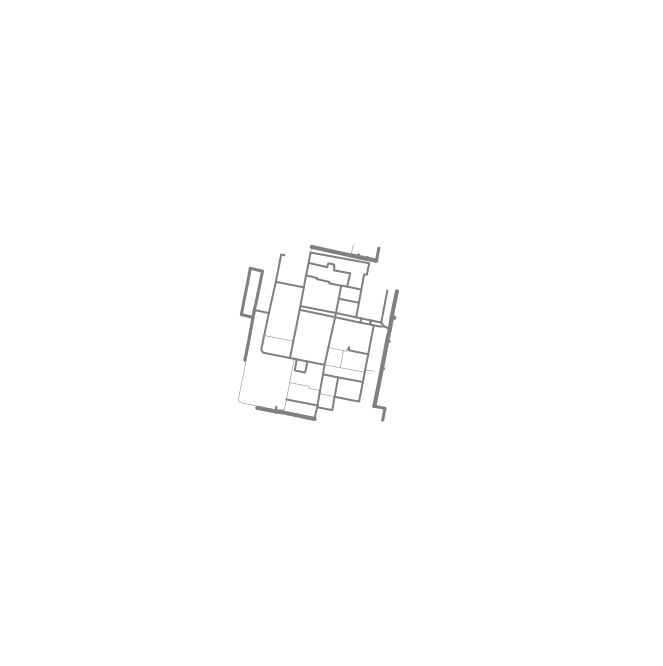

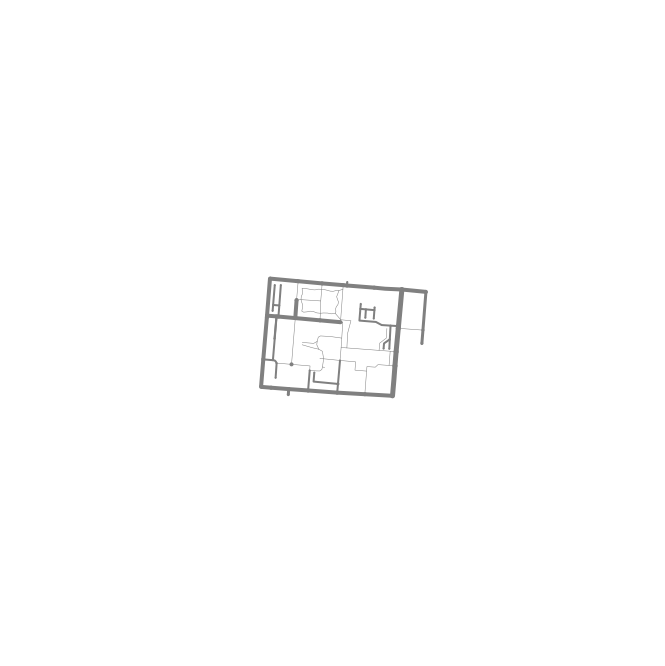

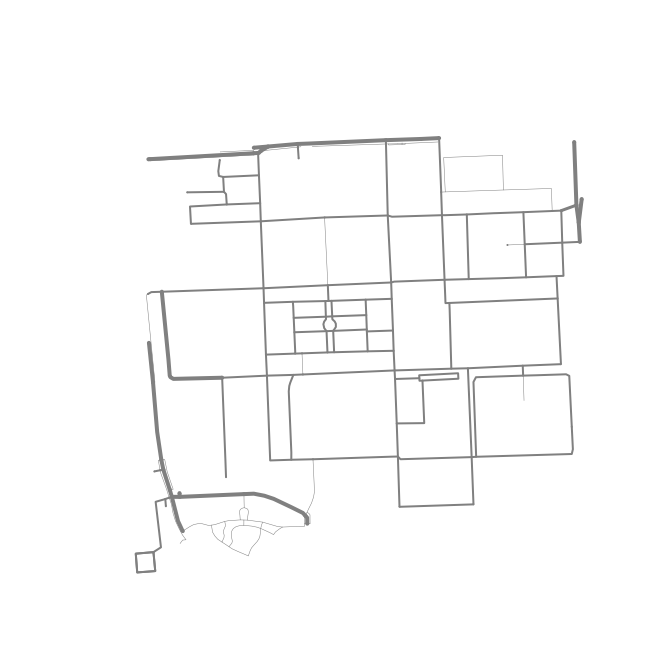

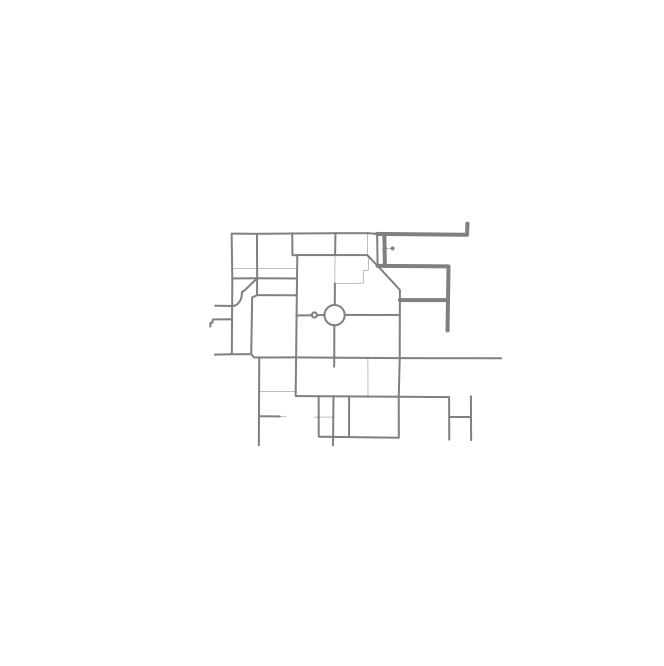

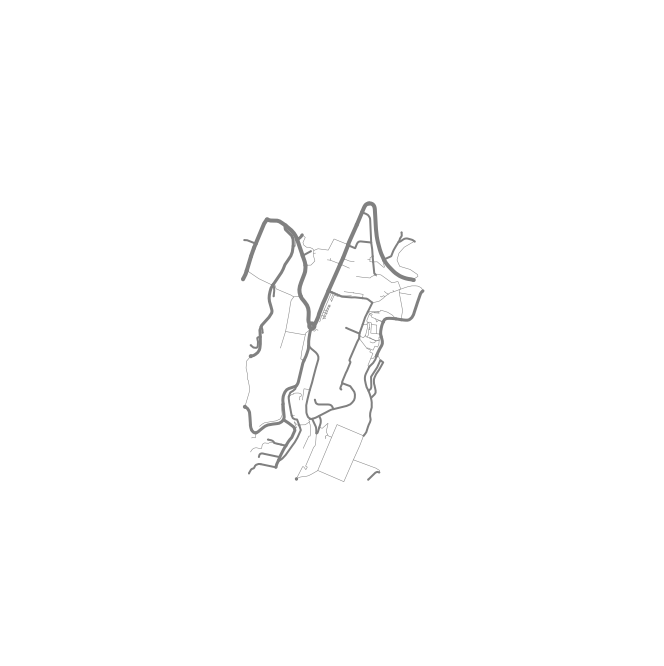

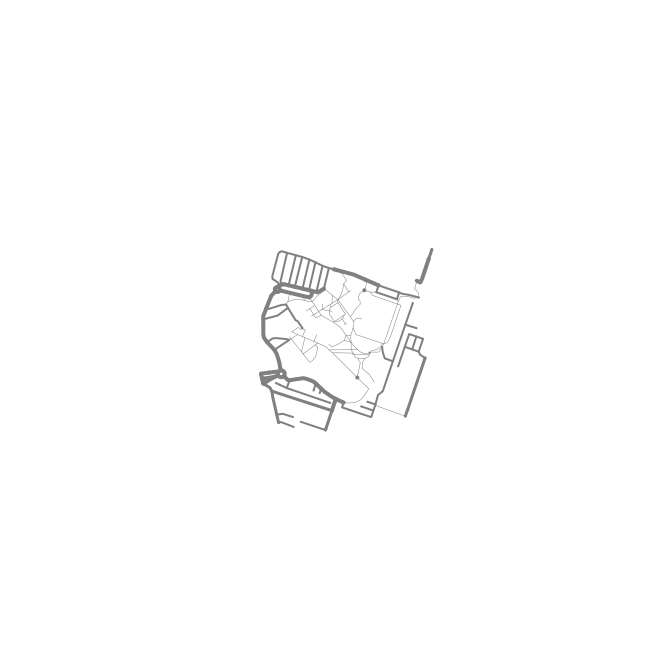

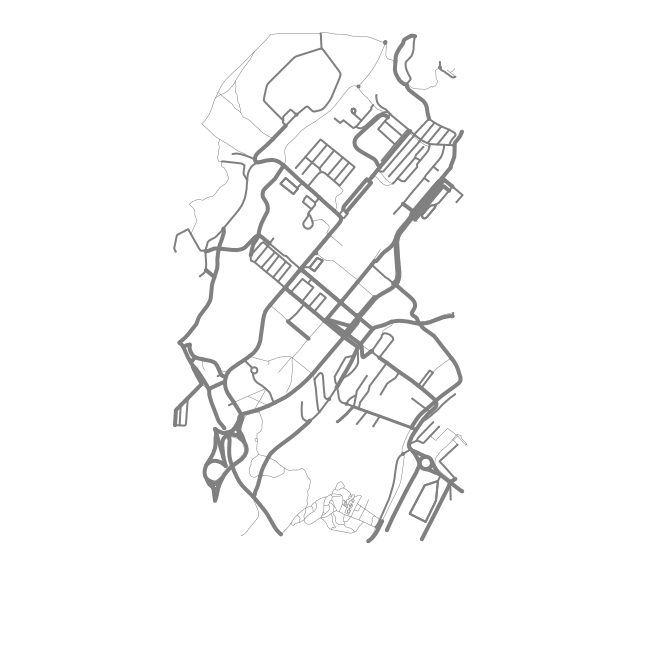

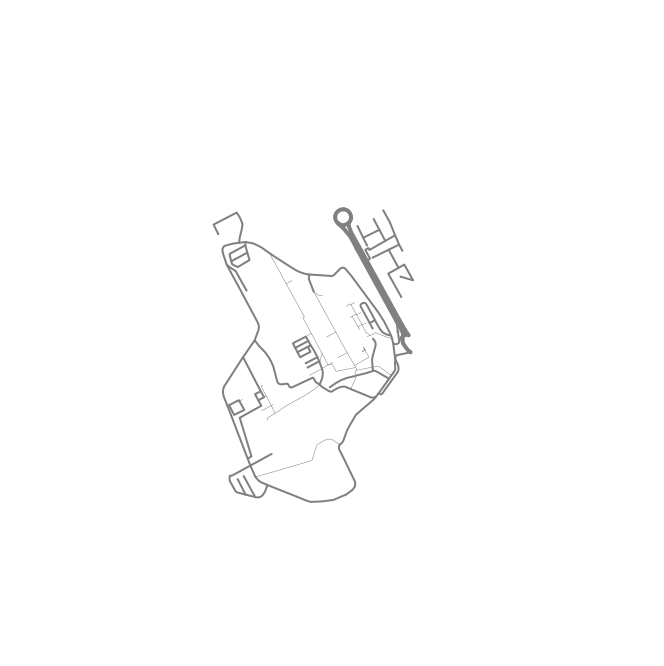

In [130]:
sitePOIDataFromFile = pd.read_csv('E:/AAA_Study/202003_GraduationProject/MapData/OSMData/POI_campus_final/1.csv')
for i in range(len(sitePOIDataFromFile)):
    osmid = str(sitePOIDataFromFile.iloc[i]['OSMID'])
    off_north = sitePOIDataFromFile.iloc[i]['north']
    off_south = sitePOIDataFromFile.iloc[i]['south']
    off_east = sitePOIDataFromFile.iloc[i]['east']
    off_west = sitePOIDataFromFile.iloc[i]['west']
    
    G = ox.graph_from_bbox(off_north,off_south,off_east,off_west)
    street_widths = {'footway' : 0.5,
                     'steps' : 0.5,
                     'pedestrian' : 0.5,
                     'path' : 0.5,
                     'track' : 0.5,
                     'service' : 2,
                     'residential' : 3,
                     'primary' : 5,
                     'motorway' : 6}
    fig, ax = ox.plot_figure_ground(G=G, network_type='all',bgcolor='w',edge_color='grey',fig_length = 12 ,
                                    street_widths=street_widths,save=False,show=True)


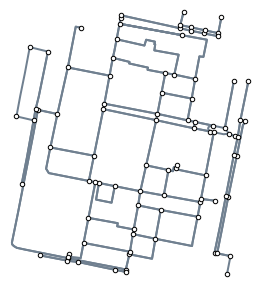

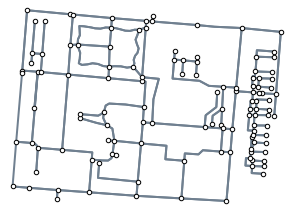

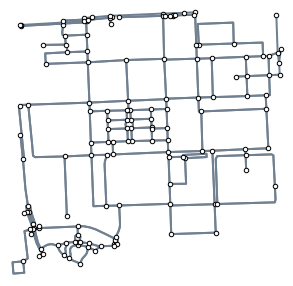

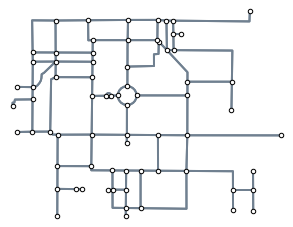

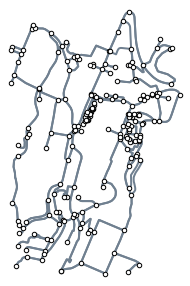

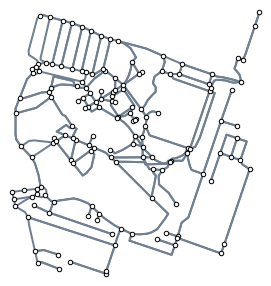

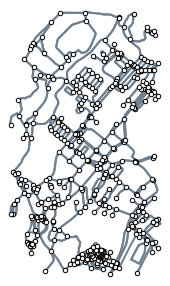

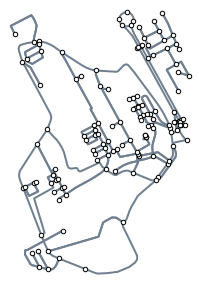

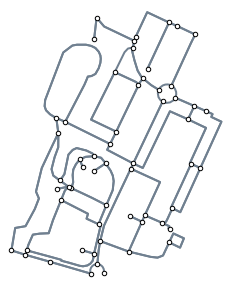

In [5]:
sitePOIDataFromFile = pd.read_csv('E:/AAA_Study/202003_GraduationProject/MapData/OSMData/POI_campus_final/1.csv')
for i in range(len(sitePOIDataFromFile)):
    osmid = str(sitePOIDataFromFile.iloc[i]['OSMID'])
    off_north = sitePOIDataFromFile.iloc[i]['north']
    off_south = sitePOIDataFromFile.iloc[i]['south']
    off_east = sitePOIDataFromFile.iloc[i]['east']
    off_west = sitePOIDataFromFile.iloc[i]['west']
    G = ox.graph_from_bbox(off_north,off_south,off_east,off_west)

    
    fig, ax = ox.plot_graph(G, node_color='w', node_edgecolor='k', node_size=20, node_zorder=3, 
                           edge_color='slategrey', edge_linewidth=2, edge_alpha=1,fig_height=5,fig_width=5,dpi=300,save=True,filename=osmid)

### 5.4 获取建筑轮廓

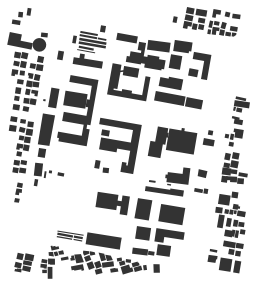

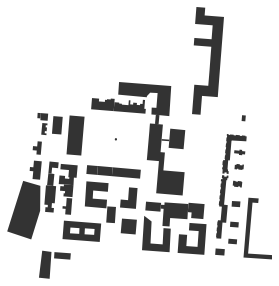

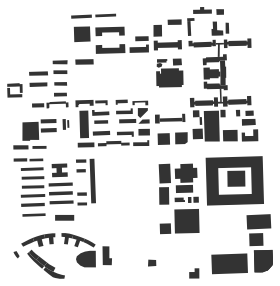

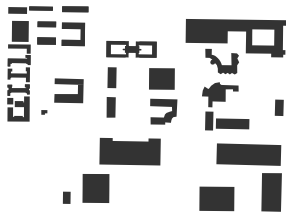

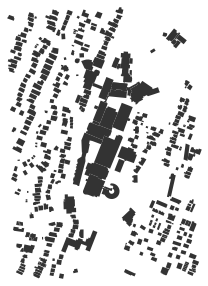

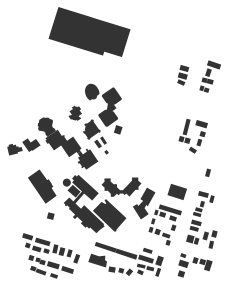

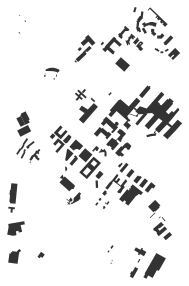

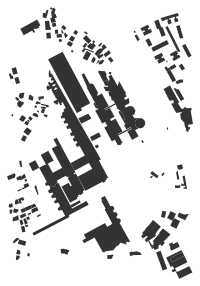

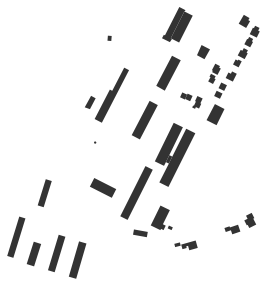

In [8]:
sitePOIDataFromFile = pd.read_csv('E:/AAA_Study/202003_GraduationProject/MapData/OSMData/POI_campus_final/1.csv')
for i in range(len(sitePOIDataFromFile)):
    osmid = str(sitePOIDataFromFile.iloc[i]['OSMID'])
    off_north = sitePOIDataFromFile.iloc[i]['north']
    off_south = sitePOIDataFromFile.iloc[i]['south']
    off_east = sitePOIDataFromFile.iloc[i]['east']
    off_west = sitePOIDataFromFile.iloc[i]['west']
    
    gdf = footprints_from_bbox(off_north,off_south,off_east,off_west)
    gdf_proj = ox.project_gdf(gdf)
    
#     areas = gdf_proj.area
#     print(areas)
    
    fig, ax = ox.footprints.plot_footprints(gdf_proj, bgcolor='w', color='#333333', set_bounds=False,
                                        save=True, show=True, close=False,figsize=(5,5),dpi=300,filename=osmid+"fp")

# ----------保存图像----------
### 8 保存图像作为可视化资料

In [11]:
sitePOIDataFromFile = pd.read_csv('E:/AAA_Study/202003_GraduationProject/MapData/OSMData/POI_extract_campus/brazil_latest_university.csv')
print(sitePOIDataFromFile.shape)
sitePOIDataFromFile.head()

(1944, 14)


,OSMID,name,center_lat,center_lon,north,south,east,west,off_north,off_south,off_east,off_west,site_analyze_length,site_analyze_width
0,8665758,Pontifícia Universidade Católica de Minas Gerais,-19.922275,-43.993817,-19.917750,-19.926270,-43.988853,-43.995929,-19.913226,-19.930265,-43.983888,-43.998042,1894.650355,1479.583273
1,24610282,Universidade Federal do Paraná Campus Centro P...,-25.450598,-49.232737,-25.444522,-25.457736,-49.229839,-49.238854,-25.438447,-25.464875,-49.226942,-49.244972,2938.681760,1810.266611
2,24611303,Colégio,-25.424063,-49.266016,-25.422707,-25.425079,-49.264329,-49.267634,-25.421351,-25.426094,-49.262642,-49.269251,527.419776,663.717161
3,24781907,Pontifícia Universidade Católica do Paraná PUCPR,-25.452841,-49.250370,-25.447544,-25.458033,-49.248603,-49.253048,-25.442246,-25.463225,-49.246835,-49.255727,2332.758366,892.777002
4,28738299,Pontifícia Universidade Católica - Contagem,-19.940680,-44.076271,-19.937412,-19.945435,-44.074799,-44.077030,-19.934144,-19.950190,-44.073326,-44.077790,1784.233793,466.531023


In [7]:
#仿照osmnx里的方法写一个footprints_from_bbox
def footprints_from_bbox(north,south,east,west, footprint_type='building', retain_invalid=False,
                          custom_settings=None):

    return ox.create_footprints_gdf(north=north, south=south, east=east, west=west,
                                 footprint_type=footprint_type, retain_invalid=retain_invalid,
                                 custom_settings=custom_settings)
def imageDowmloader(sites_projected_gdf,sitePOIDataFromFile):
    starttime = time.time()
    invalid_data_id = []
    for i in range(0,len(sites_projected_gdf)):
        geometry = sites_projected_gdf.iloc[i]['geometry']
        osmid = str(sitePOIDataFromFile.iloc[i]['OSMID'])
        north = sitePOIDataFromFile.iloc[i]['north']
        south = sitePOIDataFromFile.iloc[i]['south']
        east = sitePOIDataFromFile.iloc[i]['east']
        west = sitePOIDataFromFile.iloc[i]['west']
        off_north = sitePOIDataFromFile.iloc[i]['off_north']
        off_south = sitePOIDataFromFile.iloc[i]['off_south']
        off_east = sitePOIDataFromFile.iloc[i]['off_east']
        off_west = sitePOIDataFromFile.iloc[i]['off_west']
        g_west, g_south, g_east, g_north = geometry.bounds
        fig_ratio = (g_north-g_south)/(g_east-g_west)
        
        filepath = 'E:/AAA_Study/202003_GraduationProject/zbzCode/images/brazil/'+ osmid + '.jpg'
        fig_width = 6
        fig_height = 6*fig_ratio
        try:
            footprints_gdf = footprints_from_bbox(north,south,east,west)
            roadnetwork_graph = ox.graph_from_bbox(off_north,off_south,off_east,off_west)
            projected_graph = ox.project_graph(roadnetwork_graph)
            projected_gdf = ox.project_gdf(footprints_gdf)
            fig1, ax1 = ox.plot_graph(projected_graph, fig_height=fig_height,fig_width=fig_width, show=False, 
                                    close=False,save=False,bgcolor='#363737',edge_linewidth=2.5, edge_color='white',node_alpha = 0.0)
            fig, ax = ox.footprints.plot_footprints(projected_gdf, fig=fig1, ax=ax1, set_bounds=False,color='silver',
                                        save=False, show=False, close=False)
            plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 5, wspace = 5)
            plt.margins(0,0)

            patch = PolygonPatch(geometry, fc='grey', ec='grey', linewidth=3, alpha=0.8, zorder=-1)
            ax.add_patch(patch)
            ax.set_ylim((g_south, g_north))
            ax.set_xlim((g_west, g_east))

            fig.savefig(filepath, facecolor='#363737')
            plt.close()
            if (i+1)%50==0:
                print(i+1,' images saved')
        except:
            invalid_data_id.append(osmid)
            plt.close()
            print('no building footprints or no network graph, invalid data: ',osmid)

    df = pd.DataFrame(invalid_data_id,columns=['invalid_id'])
    df.to_csv('E:/AAA_Study/202003_GraduationProject/zbzCode/images/brazil/invalid.csv',index=0,encoding='utf-8-sig')
    endtime = time.time()
    print('step total time:', round(endtime - starttime, 2),'secs')

In [ ]:
imageDowmloader(sites_projected_gdf,sitePOIDataFromFile)

# ----------匹配推荐----------

### 根据向量计算出最接近若干结果

In [6]:
def dist_calculate(vec1, vec2):
    '''
    计算任意维度向量欧氏距离
    '''
    if len(vec1)==len(vec2):
        each_sum = 0
        for i in range(len(vec1)):
            each_sum = each_sum + (vec1[i]-vec2[i])*(vec1[i]-vec2[i])
        return math.sqrt(each_sum)
    else:
        print('Cannot calculate 2 vectors of unequal length')
        return 100000.0

In [13]:
def recommend_by_site_shape(matchNum,input_vector,vector_list,osmid_list):
    assert (len(vector_list)==len(osmid_list)),'Database error'
    dists = []
    ordered_dists = []
    for i in range(len(vector_list)):
        dist = dist_calculate(input_vector,vector_list[i])
        dists.append(dist)
    ordered_dists = dists.copy()
    ordered_dists.sort()
    for m in range(10):
        print(ordered_dists[m])
    for j in range(matchNum):
        index = dists.index(ordered_dists[j])
        osmid = str(osmid_list[index])
        print(osmid)
        try:
            img=Image.open('E:/AAA_Study/202003_GraduationProject/zbzCode/images/0_database/'+osmid+'.jpg')
            plt.imshow(img)
            plt.axis('off')
            plt.show()
        except:
            print('no file')

def recommend_by_image(matchNum,input_vector,image_vectors,image_ids,show_image=True):
    assert (len(image_vectors)==len(image_ids)),'Database error'
    recommend_ids = []
    dists = []
    ordered_dists = []
    for i in range(len(image_vectors)):
        dist = dist_calculate(input_vector,image_vectors[i])
        dists.append(dist)
    ordered_dists = dists.copy()
    ordered_dists.sort()
    
    for j in range(matchNum):
        index = dists.index(ordered_dists[j])
        osmid = str(image_ids[index])
        print(osmid,'---',ordered_dists[j])
        recommend_ids.append(osmid)
        if show_image==True:
            try:
                img=Image.open('E:/AAA_Study/202003_GraduationProject/zbzCode/images/0_database/'+osmid)
                plt.imshow(img)
                plt.axis('off')
                plt.show()
            except:
                print('no file')
    return recommend_ids

In [ ]:
input_vector =[37.59611080508047, 69.41732922722477, 103.24633658802502, 137.32205143353272, 171.4972607576403, 205.7224630894393, 239.97634796555064, 274.24824967073835, 281.05142802870165, 288.64306403885575, 299.9937182805079, 314.69690651013667, 332.3079209040824, 352.3910682656376, 369.59491263363697, 344.7429814124994, 321.6388446549193, 300.68566463664826, 282.3626937367501, 267.21154930096816, 255.79646736151972, 248.63256568418686, 246.01308197441972, 248.18801766533753, 255.04217933906, 266.1808290253898, 251.4417303626972, 221.11399000059154, 192.13627650559715, 165.22045967176123, 141.54769940949268, 123.00488401421843, 112.1657307016799, 140.4776914978728, 174.66776021724652, 207.04489926231122, 208.16378615279146, 214.83303467960602, 226.5630223207038, 242.62084153220192, 262.21258890021886, 284.6093993159322, 309.20232526527917, 335.5087854128331, 363.1565937693996, 391.86193675381406, 421.40875966686673, 405.5775118429141, 392.11910546499837, 381.2848895483678, 359.9594403680697, 326.73993592994856, 293.77486638951785, 263.9828622685408, 255.23198921109682, 250.9109093504599, 251.24828340658402, 230.15394055744264, 196.3058833693469, 162.65811601632313, 129.3670164137631, 96.801273415577, 66.04277025697017, 41.34377632500215]

# input_vector = [247.6693964230757, 252.76184180673775, 264.65891439577825, 282.5022244362393, 305.2507923009351, 331.89751300051614, 367.3207246621121, 403.19493160090383, 396.3814741932224, 367.87323405321223, 357.9836307916866, 351.0046277948006, 338.5003109188468, 330.6003312834947, 314.893474485915, 304.346176334648, 299.5040289743755, 287.351221785518, 290.156986116492, 299.02976786506764, 309.45690017391144, 315.5274384235588, 276.0947426052802, 269.07568363953874, 291.6084705837145, 264.9095379335002, 234.67987215244136, 213.24762308899727, 249.92618259724165, 288.19961535159337, 327.5092569327421, 367.5227639359517, 408.0331165386695, 395.47567558915597, 387.1929355241307, 345.35472722974384, 303.708632745816, 264.5717638818221, 235.38843896593374, 225.72422357515654, 241.7339940619881, 272.9956031494301, 270.051035621594, 252.91094063461705, 289.30706745279093, 323.90706716494265, 341.3210969802827, 380.34637838030903, 420.04049494883805, 415.33523093829126, 392.1882189717274, 371.12690452955087, 354.7846484891304, 322.78161675221435, 293.8026464609653, 299.0775103986751, 276.71773094933843, 295.6981200071253, 294.79088877916286, 289.3741546078865, 280.19360194137624, 277.28220970690893, 276.008164416422, 250.50852688753272]
print(len(input_vector))
shape_data = pd.read_csv('E:/AAA_Study/202003_GraduationProject/MapData/OSMData/1_site_shape/site_shape_all.csv')
vector_list = site_shape_data['site_shape_vector']
osmid_list = site_shape_data['OSMID']
print(len(vector_list))


recommend_by_site_shape(15,input_vector=input_vector,vector_list=vector_list,osmid_list=osmid_list)

In [2]:
def load_image_vectors(vector_path):
    '''
    从pixplot的输出结果读取所有2048维的npy文件
    '''
    print(' * loading image vectors')
    image_vectors = []
    image_ids = []
    vector_files = os.listdir(vector_path)

    for i, vec in enumerate(vector_files):
        image_ids.append(vec[0:vec.find('.npy')])
        vector = os.path.join(vector_path,vec)
        image_vectors.append(np.load(vector).tolist())
        if (i+1)%100==0:
            print(' * loaded', i+1, 'of', len(vector_files), 'image vectors')
        elif i==len(vector_files)-1:
            print(' * loaded', i+1, 'of', len(vector_files), 'image vectors')
    print('Done!')
    return image_vectors, image_ids

In [9]:
vector_path = 'C:/Users/zhangbz/output1/output/data/image-vectors'
image_vectors,image_ids = load_image_vectors(vector_path)

 * loading image vectors
 * loaded 100 of 11156 image vectors
 * loaded 200 of 11156 image vectors
 * loaded 300 of 11156 image vectors
 * loaded 400 of 11156 image vectors
 * loaded 500 of 11156 image vectors
 * loaded 600 of 11156 image vectors
 * loaded 700 of 11156 image vectors
 * loaded 800 of 11156 image vectors
 * loaded 900 of 11156 image vectors
 * loaded 1000 of 11156 image vectors
 * loaded 1100 of 11156 image vectors
 * loaded 1200 of 11156 image vectors
 * loaded 1300 of 11156 image vectors
 * loaded 1400 of 11156 image vectors
 * loaded 1500 of 11156 image vectors
 * loaded 1600 of 11156 image vectors
 * loaded 1700 of 11156 image vectors
 * loaded 1800 of 11156 image vectors
 * loaded 1900 of 11156 image vectors
 * loaded 2000 of 11156 image vectors
 * loaded 2100 of 11156 image vectors
 * loaded 2200 of 11156 image vectors
 * loaded 2300 of 11156 image vectors
 * loaded 2400 of 11156 image vectors
 * loaded 2500 of 11156 image vectors
 * loaded 2600 of 11156 image vect

23123408.jpg --- 0.0


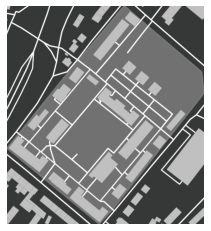

797688261.jpg --- 12.875676386407187


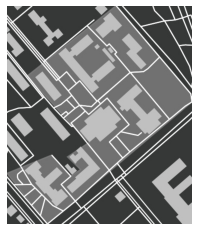

565801518.jpg --- 13.630016926244101


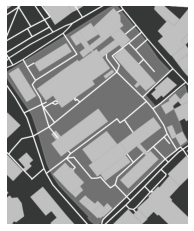

33135527.jpg --- 13.676215862459555


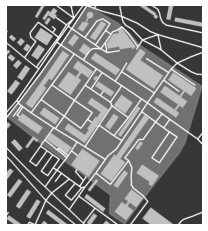

27122735.jpg --- 13.806605780344546


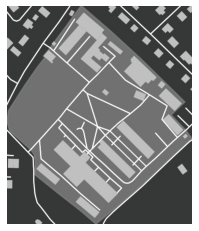

['23123408.jpg',
 '797688261.jpg',
 '565801518.jpg',
 '33135527.jpg',
 '27122735.jpg']

In [20]:
input_vector = np.load('C:/Users/zhangbz/output1/output/data/image-vectors/23123408.jpg.npy').tolist()
recommend_by_image(5,input_vector,image_vectors,image_ids)

### 将结果内的建筑和道路match进目标地块

In [31]:
def get_input_info(campus_POI_csv, site_gdf_data, input_id):
    '''
    获取输入数据的轮廓和场地以外一定范围的道路和建筑，返回GeoDataFrame、
    '''
    #读取学校POI的csv文件
    campus_POI = pd.read_csv(campus_POI_csv)
    
    #获取输入id在POI数据和地块gdf数据的行数位置
    input_POI_index = campus_POI[campus_POI.OSMID.isin([input_id])].index.tolist()
    input_unproj_gdf_index = site_gdf_data[site_gdf_data.OSMID.isin([input_id])].index.tolist()
    input_gdf_index = site_unproj_gdf_data[site_unproj_gdf_data.OSMID.isin([input_id])].index.tolist()
    print(input_POI_index,input_unproj_gdf_index,input_gdf_index)
    
    #将地块平移至原点
    input_polygon = site_gdf_data.iloc[input_gdf_index[0]]["geometry"]
    input_polygon = affinity.translate(input_polygon,xoff=input_polygon.centroid.x*(-1), yoff=input_polygon.centroid.y*(-1))
    
    #构造输入地块的GeoDataFrame
    input_site_data = [
        {
            "type": "Feature",
            "geometry": input_polygon,
            "properties": {
                "OSMID": input_id,
                "continent": campus_POI.iloc[input_POI_index[0]]["continent"],
                "country": campus_POI.iloc[input_POI_index[0]]["country"],
                "name": campus_POI.iloc[input_POI_index[0]]["name"],
                "geometry_type": site_gdf_data.iloc[input_POI_index[0]]["geometry_type"]
            }
        }
    ]
    input_site_gdf = gpd.GeoDataFrame.from_features(input_site_data)
    
#     footprints_unproj_gdf = ox
    
    return input_site_gdf

In [32]:
campus_POI_csv = "E:/AAA_Study/202003_GraduationProject/MapData/OSMData/POI_campus_final/all_university.csv"
input_site_gdf = get_input_info(campus_POI_csv,site_gdf_data,"23123408")

[3289] [4733] [4733]


In [29]:
def get_recommend_sites(campus_POI_csv, site_gdf_data, recommend_ids=None):
    """
    """
    #读取学校POI的csv文件
    campus_POI = pd.read_csv(campus_POI_csv)
    
    #获取推荐结果ids在地块gdf数据的行数位置
    recommend_unproj_gdf_indices = []
    for k in range(len(recommend_ids)):
        recommend_unproj_gdf_indices.append(site_unproj_gdf_data[site_unproj_gdf_data.OSMID.isin([recommend_ids[k]])].index.tolist()[0])
    print(recommend_unproj_gdf_indices)
    
    recommend_gdf_indices = []
    for k in range(len(recommend_ids)):
        recommend_gdf_indices.append(site_gdf_data[site_gdf_data.OSMID.isin([recommend_ids[k]])].index.tolist()[0])
    print(recommend_gdf_indices)
    
    
    #创建一个空DataFrame，用来存储推荐结果的POI数据
    recommend_POI = pd.DataFrame(columns=campus_POI.columns)
    for i in range(len(recommend_ids)):
        curr_line = campus_POI[campus_POI.OSMID.isin([recommend_ids[i]])]
        recommend_POI = pd.concat([recommend_POI,curr_line]) #type:DataFrame
        recommend_POI.reset_index(drop=True, inplace=True)
        
    #提取匹配地块unprojected的边界，获取内部建筑数据，按照推荐地块轮廓的位置，将数据平移到原点
    recommend_footprints = []
    for j in range(len(recommend_POI)):
        print(j)
        xoff = site_gdf_data.iloc[recommend_gdf_indices[j]]["geometry"].centroid.x*(-1)
        yoff = site_gdf_data.iloc[recommend_gdf_indices[j]]["geometry"].centroid.y*(-1)
        print(xoff," ",yoff)
        off_north = recommend_POI.iloc[j]["off_north"]
        off_south = recommend_POI.iloc[j]["off_south"]
        off_east = recommend_POI.iloc[j]["off_east"]
        off_west = recommend_POI.iloc[j]["off_west"]

#         unproj_polygon = site_unproj_gdf_data.iloc[recommend_unproj_gdf_indices[j]]["geometry"]
#         footprints_gdf = ox.footprints_from_polygon(unproj_polygon)
        footprints_gdf = footprints_from_bbox(off_north,off_south,off_east,off_west)
        projected_gdf = ox.project_gdf(footprints_gdf)
        projected_gdf.reset_index(drop=True, inplace=True)
        
        #将原geometry行删除，替换为平移到原点的geometry
        translated_fps = projected_gdf["geometry"].translate(xoff,yoff)
        print(translated_fps)
        projected_gdf.drop(columns=["geometry"])
        
        new_gdf = gpd.GeoDataFrame(projected_gdf, geometry=translated_fps)

        recommend_footprints.append(new_gdf)
    return recommend_POI,recommend_footprints
        #roadnetwork_graph = ox.graph_from_bbox(off_north,off_south,off_east,off_west)

In [30]:
recommend_POI,recommend_footprints = get_recommend_sites(campus_POI_csv,site_gdf_data,["769186239","502875300","88381816"])

[14251, 6453, 11944]
[14251, 6453, 11944]
0
-572040.616148562   -4370946.466914225
0     POLYGON ((-134.153 -230.899, -129.997 -232.015...
1     POLYGON ((-35.103 -209.724, 7.547 -211.469, 7....
2     POLYGON ((-69.297 -275.893, -37.590 -277.208, ...
3     POLYGON ((26.895 -316.399, 18.823 -315.952, 11...
4     POLYGON ((69.923 -280.947, 100.872 -275.764, 9...
5     POLYGON ((126.779 -230.571, 227.339 -234.085, ...
6     POLYGON ((-272.236 -382.674, -256.339 -386.689...
7     POLYGON ((291.196 -130.355, 293.927 -225.683, ...
8     POLYGON ((5.432 -185.594, 13.512 -178.571, 11....
9     POLYGON ((96.030 -149.201, 116.881 -136.509, 1...
10    POLYGON ((169.210 -51.823, 182.770 -94.861, 19...
11    POLYGON ((191.039 -140.468, 189.435 -202.750, ...
12    POLYGON ((219.346 -16.071, 230.543 -4.934, 274...
13    POLYGON ((103.118 29.030, 112.045 36.461, 160....
14    POLYGON ((5.468 -23.956, 32.095 -19.235, 33.79...
15    POLYGON ((-52.440 149.164, -41.700 151.173, -4...
16    POLYGON ((-116.

In [26]:
recommend_POI

,continent,country,OSMID,name,center_lat,center_lon,north,south,east,west,off_north,off_south,off_east,off_west,site_analyze_length,site_analyze_width
0,North_America,us,769186239,Fairmont State University,39.485158,-80.162989,39.488990,39.481723,-80.158521,-80.167129,39.492822,39.478289,-80.154053,-80.171269,1615.973630,1477.495228
1,Asia,india,502875300,"Amity University, Noida",28.544005,77.332527,28.547371,28.540519,77.337004,77.329545,28.550736,28.537033,77.341481,77.326562,1523.659602,1457.256825
2,Europe,ukraine,88381816,NaN,48.446548,35.052257,48.448682,48.443858,35.056569,35.049705,48.450815,48.441168,35.060880,35.047153,1072.786413,1012.485986


In [28]:
recommend_footprints[0]

,nodes,building,name,geometry,gnis:feature_id,building:levels,description
0,"[2690697636, 2690697637, 2690697638, 269069763...",university,Hunt Haught Hall,"POLYGON ((-134.153 -230.899, -129.997 -232.015...",NaN,NaN,NaN
1,"[2690697661, 2690697662, 2690697663, 269069766...",university,Ruth Ann Musick Library,"POLYGON ((-35.103 -209.724, 7.547 -211.469, 7....",NaN,NaN,NaN
2,"[2690697672, 2690697673, 2690697674, 269069767...",university,Engineering Technology Building,"POLYGON ((-69.297 -275.893, -37.590 -277.208, ...",NaN,NaN,NaN
3,"[2690703705, 2690703706, 2690703707, 269070368...",university,Wallman Hall,"POLYGON ((26.895 -316.399, 18.823 -315.952, 11...",NaN,NaN,NaN
4,"[2690703708, 2690703709, 2690703710, 269070371...",university,Turley Center,"POLYGON ((69.923 -280.947, 100.872 -275.764, 9...",NaN,NaN,NaN
5,"[2690703731, 2690703732, 2690703733, 269070373...",university,Hardway Hall,"POLYGON ((126.779 -230.571, 227.339 -234.085, ...",NaN,NaN,NaN
6,"[2690703897, 2690703898, 2690703899, 269070390...",yes,Parking Deck,"POLYGON ((291.196 -130.355, 293.927 -225.683, ...",NaN,NaN,NaN
7,"[2690706272, 2690706273, 2690706274, 269070627...",university,Education Building,"POLYGON ((5.432 -185.594, 13.512 -178.571, 11....",NaN,NaN,NaN
8,"[2690706288, 2690706289, 2690706290, 269070389...",university,Falcon Center,"POLYGON ((96.030 -149.201, 116.881 -136.509, 1...",NaN,NaN,NaN
9,"[2690706312, 367808293, 2690706313, 2690706314...",university,Morrow Hall,"POLYGON ((169.210 -51.823, 182.770 -94.861, 19...",1718082,NaN,NaN


In [41]:
def recommend_match_image(input_site_gdf,recommend_footprints):
    fig, ax = ox.footprints.plot_footprints(recommend_footprints, set_bounds=False,color='orange',save=False, show=False, close=False)
    plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 5, wspace = 5)
    plt.margins(0,0)
    
    geometry = input_site_gdf.iloc[0]["geometry"]
    g_west, g_south, g_east, g_north = geometry.bounds
    
    patch = PolygonPatch(geometry, fc='grey', ec='grey', linewidth=3, alpha=0.8, zorder=-1)
    ax.add_patch(patch)
    ax.set_ylim((g_south, g_north))
    ax.set_xlim((g_west, g_east))

    fig.savefig("0.jpg", facecolor='#363737')
    plt.close()

In [43]:
recommend_match_image(input_site_gdf,recommend_footprints[1])